**Universidade Tecnológica Federal do Paraná**

**Programa de Pós-Graduação em Informática (PPGI)**

**Disciplina:** Linguagens de Programação

**Professores:** Dr. Adriano Rivolli (UTFPR-CP) e Dr. Marlon Marcon (UTFPR-DV)

**Aluno:** Wellington Guimarães de Almeida


# Projeto Avaliativo


## Descrição do projeto


## Pré-requisitos

Para a realização deste projeto faz-se necessário a instalação e importação das seguintes bibliotecas:

-   [Pandas](https://pandas.pydata.org/) - Biblioteca de análise e manipulação de dados
-   [Matplotlib](https://matplotlib.org/) - Biblioteca para criação de visualizações de dados
-   [NumPy](https://numpy.org/) - Biblioteca para realização de cálculos numéricos
-   [ipywidgets](https://github.com/jupyter-widgets/ipywidgets) - Biblioteca de componentes visuais interativos
-   [Geopandas](https://geopandas.org/) - Biblioteca para manipulação de dados geoespaciais
-   [Descartes](https://pypi.org/project/descartes/) - Biblioteca para plotagem de objetos geométricos no matplotlib


### Instalação das bibliotecas necessárias


In [52]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install ipywidgets
!pip install geopandas
!pip install descartes


### Importação das bibliotecas necessárias

Instaladas as dependências necessárias, as bibliotecas utilizadas devem ser importadas para que possam ser utilizadas no projeto.

In [53]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import geopandas as gpd

## Definição de parâmetros da análise

A análise realizada neste projeto diz respeito ao estudo da distribuição de ERB's (Estações Rádio Base), destinadas à prestação do serviço de telefonia móvel no território brasileiro.

Para atender ao requisito proposto de parametrização da análise, o escopo de execução de todo o código subsequente ficara restrito à unidade da federação selecionada a seguir.

In [54]:
uf_list = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT',
           'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

# Definição de parâmetros
titulo = widgets.Label('Selecione o escopo da análise:')

uf_select = widgets.Dropdown(
    options=uf_list,
    value='PR',
    description='Estado: ')

widgets.VBox([titulo, uf_select])


## Desenvolvimento


### Carga dos dados

Os dados são carregados a partir de arquivos `csv` obtidos em consulta ao cadastro de licenciamentos para emissão de radiofrequência, disponibilizado pela Anatel (Agência Nacional de Telecomunicações) em <https://sistemas.anatel.gov.br/se/public/view/b/licenciamento.php>.

Foi realizada a pesquisa por estado tendo como parâmetro de filtragem dos registros o código de registro correspondente ao Serviço Móvel Pessoal (`010`).

Após a obtenção dos dados, estes foram disponibilizados em <https://github.com/WellingtonAlmeida/erbs>.


In [55]:
URL_REPOSITORIO = 'https://github.com/WellingtonAlmeida/erbs'
uf = uf_select.value.lower()

# Função para recuperação dos dados brutos das antenas
def carrega_dados(uf):
    url_antenas = URL_REPOSITORIO+'/raw/main/dados-anatel/'+uf+'.csv'
    df_antenas = pd.read_csv(url_antenas, sep=';')
    return df_antenas

df_antenas = carrega_dados(uf)

/tmp/ipykernel_42857/3847286385.py:10: DtypeWarning: Columns (13,18,19,20,22,23,24,28,29,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  df_antenas = carrega_dados(uf)


In [56]:
# Verificação da carga de dados das antenas
df_antenas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60426 entries, 0 to 60425
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Status.state                 60426 non-null  object 
 1   NomeEntidade                 60426 non-null  object 
 2   NumFistel                    60426 non-null  int64  
 3   NumServico                   60426 non-null  int64  
 4   NumAto                       60426 non-null  int64  
 5   NumEstacao                   60426 non-null  int64  
 6   EnderecoEstacao              60408 non-null  object 
 7   EndComplemento               13893 non-null  object 
 8   SiglaUf                      60426 non-null  object 
 9   CodMunicipio                 60411 non-null  float64
 10  DesignacaoEmissao            60426 non-null  object 
 11  Tecnologia                   60426 non-null  object 
 12  tipoTecnologia               1727 non-null   object 
 13  meioAcesso      

### Tratamento dos dados

Após recuperados os dados, estes são tratados visando a eliminação de registros inválidos e melhoria da organização do conjunto de dados obtido, simplificando assim o processo de análise posterior.


In [57]:
# Tratamento dos dados obtidos
def trata_dados(df):
    # Seleção das colunas utilizadas na análise
    colunas = ['NomeEntidade', 'NumEstacao', 'SiglaUf', 'CodMunicipio', 'Tecnologia',  'AlturaAntena',
               'PotenciaTransmissorWatts', 'DataLicenciamento', 'DataPrimeiroLicenciamento', 'Latitude', 'Longitude']
    df_antenas = df[colunas]

    # Atribuição de novos nomes às colunas
    novos_nomes_colunas = ['operadora', 'estacao', 'uf', 'codigo_municipio', 'tecnologia', 'altura_antena',
                           'potencia_transmissor', 'data_licenciamento', 'data_primeiro_licenciamento', 'latitude', 'longitude']
    df_antenas.columns = novos_nomes_colunas

    # Descarte dos registros com dados incompletos
    df_antenas = df_antenas.dropna()

    # Descarta registros com coordenadas fora do limite nacional
    LIMITE_NORTE = 6
    LIMITE_SUL = -34
    LIMITE_LESTE = -35
    LIMITE_OESTE = -73
    selecao = df_antenas[df_antenas['latitude'] > LIMITE_NORTE].index
    df_antenas.drop(selecao, inplace=True)
    selecao = df_antenas[df_antenas['latitude'] < LIMITE_SUL].index
    df_antenas.drop(selecao, inplace=True)
    selecao = df_antenas[df_antenas['longitude'] > LIMITE_LESTE].index
    df_antenas.drop(selecao, inplace=True)
    selecao = df_antenas[df_antenas['longitude'] < LIMITE_OESTE].index
    df_antenas.drop(selecao, inplace=True)

    # Ajuste nos tipos de dados
    df_antenas['codigo_municipio'] = df_antenas['codigo_municipio'].astype(int)
    df_antenas['data_licenciamento'] = pd.to_datetime(
        df_antenas['data_licenciamento'], format='%Y-%m-%d')
    df_antenas['data_primeiro_licenciamento'] = pd.to_datetime(
        df_antenas['data_primeiro_licenciamento'], format='%Y-%m-%d')
        
    return df_antenas


df_antenas = trata_dados(df_antenas)


In [58]:
# Verificação do tratamento dos dados de antenas
df_antenas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57389 entries, 0 to 60425
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   operadora                    57389 non-null  object        
 1   estacao                      57389 non-null  int64         
 2   uf                           57389 non-null  object        
 3   codigo_municipio             57389 non-null  int64         
 4   tecnologia                   57389 non-null  object        
 5   altura_antena                57389 non-null  float64       
 6   potencia_transmissor         57389 non-null  object        
 7   data_licenciamento           57389 non-null  datetime64[ns]
 8   data_primeiro_licenciamento  57389 non-null  datetime64[ns]
 9   latitude                     57389 non-null  float64       
 10  longitude                    57389 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(2

### Análise e Visualização dos dados

Feitos os devidos tratamentos, os dados estão prontos para a fase de análise e visualização. Para o presente projeto foram criadas alguns gráficos quantitativos e a distribuição geográfica das ERB's pelo estado selecionado.

#### Total de antenas por operadora e por tecnologia no Estado

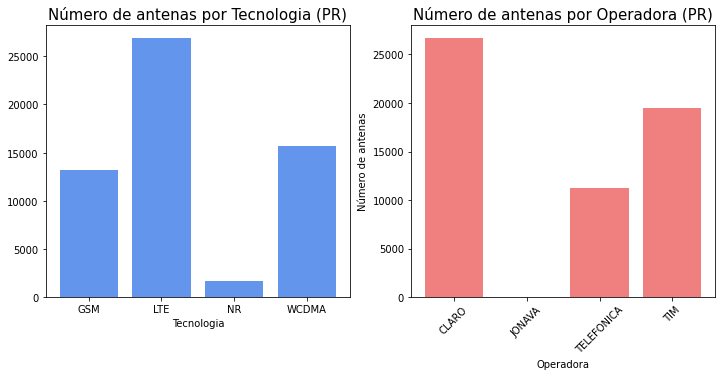

In [59]:
def gera_grafico_antenas(uf):
    df_tecnologia = df_antenas.groupby(['tecnologia']).agg(
        {'estacao': 'count'}).reset_index()
    tecnologia = df_tecnologia['tecnologia'].to_list()
    numero_antenas_tecnologia = df_tecnologia['estacao'].to_list()

    df_operadora = df_antenas.groupby(['operadora']).agg(
        {'estacao': 'count'}).reset_index()
    operadora = [o.split()[0] for o in df_operadora['operadora'].to_list()]
    numero_antenas_operadora = df_operadora['estacao'].to_list()

    fig = plt.figure(figsize=(12, 5))
    axs = fig.subplots(1, 2)

    axs[0].bar(tecnologia, numero_antenas_tecnologia,  color='cornflowerblue')
    axs[0].set_title('Número de antenas por Tecnologia ('+uf+')', fontsize=15)
    axs[0].set_xlabel('Tecnologia')

    axs[1].bar(operadora, numero_antenas_operadora, color='lightcoral')
    axs[1].set_title('Número de antenas por Operadora ('+uf+')', fontsize=15)
    axs[1].set_xlabel('Operadora')

    plt.ylabel('Número de antenas')
    plt.xticks(rotation=45)
    plt.show()


gera_grafico_antenas(uf.upper())


#### Número de antenas por tecnologia de cada operadora no Estado


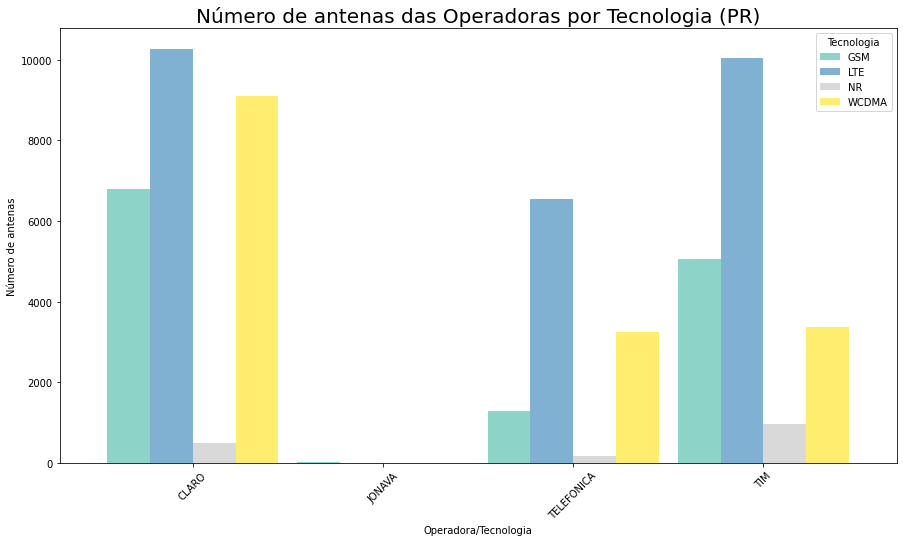

In [60]:
def gera_grafico_antenas_por_tecnologia_agrupado_por_operadora(uf):    
    df = df_antenas
    df['operadora'] = [o.split()[0] for o in df['operadora']]
    df = df_antenas.groupby(['operadora', 'tecnologia']).agg(
        {'estacao': 'count'}).reset_index()   
    df = df.pivot(index='operadora', columns='tecnologia', values='estacao')
    df.fillna(0)

    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot()
    df.plot(ax=ax, kind='bar', cmap='Set3', width=0.9)

    plt.title('Número de antenas das Operadoras por Tecnologia ('+uf+')', fontsize=20)
    plt.xlabel('Operadora/Tecnologia')
    plt.ylabel('Número de antenas')
    plt.xticks(rotation=45)
    plt.legend(title='Tecnologia')
    plt.show()


gera_grafico_antenas_por_tecnologia_agrupado_por_operadora(uf.upper())


#### Localização das ERB's


/home/wellington/.local/lib/python3.8/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/wellington/.local/lib/python3.8/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/wellington/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/wellington/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no l

<Figure size 3000x3000 with 0 Axes>

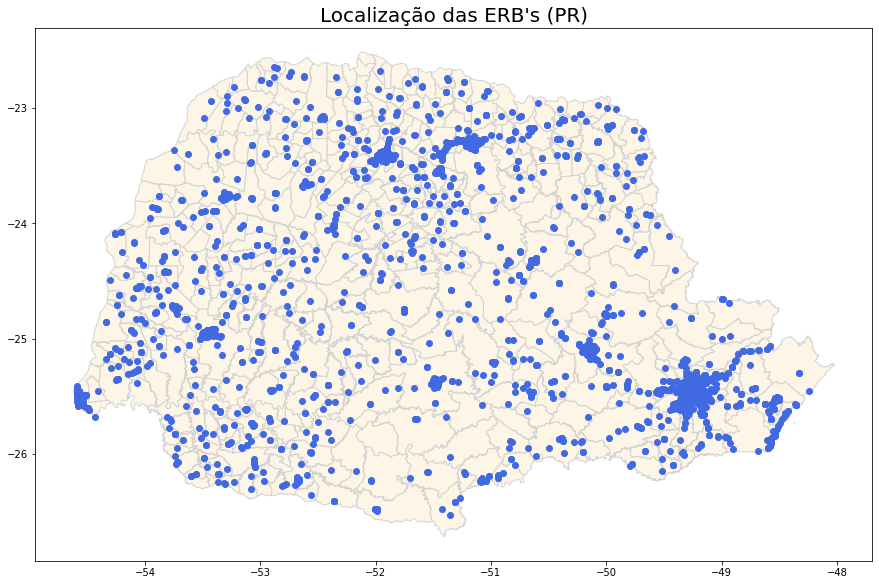

In [61]:
def gera_grafico_localizacao_erbs(uf):
    url_malha_estadual_ibge = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/UFs/'+uf+'/'+uf+'_UF_2022.zip'        
    url_malha_municipal_ibge = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/UFs/'+uf+'/'+uf+'_Municipios_2022.zip'
    plt.figure(figsize=(10,10), dpi=300)
    limite_estado = gpd.read_file(url_malha_estadual_ibge)
    limite_municipios = gpd.read_file(url_malha_municipal_ibge)

    ax = limite_municipios.plot(color='oldlace', edgecolor='lightgray', figsize=(15,15))    

    plt.title('Localização das ERB\'s ('+uf+')', fontsize=20)

    erbs = df_antenas[['estacao', 'latitude', 'longitude']].drop_duplicates()
    gdf = gpd.GeoDataFrame(erbs, geometry=gpd.points_from_xy(
        erbs.longitude, erbs.latitude))
    filtro = gdf.within(limite_estado.loc[0,'geometry'])
    gdf = gdf.loc[filtro]
    gdf.plot(ax=ax, color='royalblue')
    plt.show()

gera_grafico_localizacao_erbs(uf.upper())

A partir da análise das visualizações geradas para cada região podemos ter um panorama em relação à tecnologia predominante, a operadora com maior presença no território.

Além disso podemos visualizar a distribuição geográfica das ERB's, o que pode indicar áreas de maior concentração populacional e por consequência, indicando regiões com maiores demandas de infraestrutura e mercado consumidor.